# **EDS 296 Homework 2: Geospatial Analysis**

### Sadie Cwikiel
#### May 12, 2025

In [1]:
# Load packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import intake
import s3fs
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
import scipy.stats as stats

ERROR 1: PROJ: proj_create_from_database: Open of /opt/anaconda3/envs/eds296-stevenson/share/proj failed


## Model and Variable Selection
The geospatial analysis of the Eastern Tropical Pacific Ocean will be conducted using the following models, scenarios, and variable.

**Variable:**
- Sea surface temperature (tos)

**Models:**

The following 2 models were chosen through a process of trial and error to find models that had consistent ocean grids for the historical and future scenarios, and for which I did not run into other errors with manipulating and plotting the data.

- *ACCESS-CM2*: The Australian Community Climate and Earth System Simulator model has been developed by Australian climate research agencies over the past 15 years. ACCESS-CM2 is the coupled climate model, consisting of atmospheric, land surface, ocean, and sea ice components. The ocean component of the model is the GFDL MOM5 ocean model at 1 degree resolution. 3 common ensemble members for historical and SSP3-7.0 are analyzed for this project

Source: https://research.csiro.au/access/about/cm2/


- *MPI-ESM1-2-LR*: The Max Planck Institute for Meteorology, low resolution model. The ocean component of the model consists of the ocean biogeochemistry model HAMOCC6 and the ocean dynamic model MPIOM1.6. Ocean grid spacing is 150 km. 10 common ensemble members for historical and SSP3-7.0 are analyzed for this project

Source: https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2018MS001400



**Scenarios:**
- *Historical*: climate simulation from 1850-2015
- *SSP3-7.0*: climate simulation from 2015-2100 for middle-of-the-road scenario emissions and warming, potentially the most likely climate trajectory



## Load and Query the CMIP6 AWS Catalog
Load the CMIP6 database hosted by Amazon Web Services:

In [2]:
# Open the CMIP6 data catalog and store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

# Convert the catalog to a Pandas dataframe
cat_df = catalog.df

To make this analysis more robust, we will use averages of multiple ensemble members for each model. In the following steps, we will select models that have around 5 ensemble members in the historical period and include the variable tos (temperature at ocean surface).

In [3]:
# Specify search terms to query catalog 
# experiment_id: historical 
experiment_ids = ['historical']
# table_id: Ocean
table_id = 'Omon' 
# variable_id: sea surface temperature (tos) 
variable_id = 'tos'

# Extract the part of the catalog that goes with these search terms
res = catalog.search(experiment_id=experiment_ids, table_id=table_id, variable_id=variable_id)

# Find all unique models that ran historical simulations
print(res.df.source_id.unique())

['GFDL-CM4' 'GFDL-ESM4' 'IPSL-CM6A-LR' 'GISS-E2-1-G' 'CNRM-CM6-1'
 'BCC-CSM2-MR' 'BCC-ESM1' 'CNRM-ESM2-1' 'MIROC6' 'AWI-CM-1-1-MR' 'CESM2'
 'SAM0-UNICON' 'GISS-E2-1-H' 'CanESM5' 'CanESM5-CanOE' 'INM-CM4-8'
 'UKESM1-0-LL' 'INM-CM5-0' 'HadGEM3-GC31-LL' 'MPI-ESM-1-2-HAM' 'NESM3'
 'CAMS-CSM1-0' 'MPI-ESM1-2-LR' 'MPI-ESM1-2-HR' 'MCM-UA-1-0' 'CESM2-WACCM'
 'NorESM2-LM' 'GISS-E2-1-G-CC' 'MIROC-ES2L' 'E3SM-1-0' 'MRI-ESM2-0'
 'NorCPM1' 'FGOALS-f3-L' 'CNRM-CM6-1-HR' 'FGOALS-g3' 'NorESM2-MM'
 'ACCESS-CM2' 'ACCESS-ESM1-5' 'CESM2-WACCM-FV2' 'CESM2-FV2' 'FIO-ESM-2-0'
 'E3SM-1-1' 'HadGEM3-GC31-MM' 'E3SM-1-1-ECA' 'KACE-1-0-G' 'EC-Earth3-Veg'
 'EC-Earth3' 'AWI-ESM-1-1-LR' 'CIESM' 'CAS-ESM2-0' 'CMCC-CM2-SR5'
 'EC-Earth3-AerChem' 'TaiESM1' 'IPSL-CM5A2-INCA' 'CMCC-CM2-HR4' 'IITM-ESM'
 'EC-Earth3-Veg-LR' 'EC-Earth3-CC' 'CMCC-ESM2' 'IPSL-CM6A-LR-INCA']


Now we loop through all of these models and record how many ensemble members each of them have. 

In [4]:
# source_id: which model do you want? 
source_id = res.df.source_id.unique()

for src in source_id:
    # Print out the name of the model we're working with, to keep track of things
    print(src)
    
    # Extract the part of the catalog that goes with this model
    this_res = catalog.search(experiment_id=experiment_ids, source_id=src, table_id=table_id, variable_id=variable_id)

    # Print the unique member ids
    print(this_res.df.member_id.unique())
    
    # AND/OR print the number of unique members
    print("unique members")
    print(len(this_res.df.member_id.unique()))

GFDL-CM4
['r1i1p1f1']
unique members
1
GFDL-ESM4
['r2i1p1f1' 'r3i1p1f1' 'r1i1p1f1']
unique members
3
IPSL-CM6A-LR
['r3i1p1f1' 'r6i1p1f1' 'r4i1p1f1' 'r14i1p1f1' 'r5i1p1f1' 'r15i1p1f1'
 'r16i1p1f1' 'r27i1p1f1' 'r2i1p1f1' 'r30i1p1f1' 'r28i1p1f1' 'r31i1p1f1'
 'r8i1p1f1' 'r29i1p1f1' 'r9i1p1f1' 'r7i1p1f1' 'r26i1p1f1' 'r20i1p1f1'
 'r23i1p1f1' 'r25i1p1f1' 'r19i1p1f1' 'r21i1p1f1' 'r1i1p1f1' 'r11i1p1f1'
 'r13i1p1f1' 'r10i1p1f1' 'r17i1p1f1' 'r18i1p1f1' 'r22i1p1f1' 'r12i1p1f1'
 'r24i1p1f1' 'r32i1p1f1']
unique members
32
GISS-E2-1-G
['r1i1p1f1' 'r2i1p1f1' 'r5i1p1f1' 'r3i1p1f1' 'r4i1p1f1' 'r7i1p1f1'
 'r6i1p1f1' 'r9i1p1f1' 'r8i1p1f1' 'r10i1p1f1' 'r10i1p3f1' 'r3i1p3f1'
 'r2i1p3f1' 'r5i1p3f1' 'r1i1p3f1' 'r9i1p3f1' 'r4i1p3f1' 'r6i1p3f1'
 'r8i1p3f1' 'r101i1p1f1' 'r102i1p1f1' 'r5i1p1f2' 'r1i1p1f3' 'r4i1p1f3'
 'r5i1p1f3' 'r2i1p1f3' 'r2i1p1f2' 'r6i1p1f2' 'r10i1p1f2' 'r1i1p1f2'
 'r11i1p1f2' 'r8i1p1f2' 'r4i1p1f2' 'r9i1p1f2' 'r3i1p1f3' 'r3i1p1f2'
 'r7i1p1f2' 'r4i1p5f1' 'r10i1p5f1' 'r1i1p5f1' 'r7i1p5f1' 'r3i1p5

After running into some issues with the grids of some models, I have selected these ACCESS-CM2 and MPI-ESM1-2-LR to work with for this assignment because they each have multiple shared members across the historical and SSP3-7.0 scenario (3 and 10 members respectively). Importantly, both of the models have consistent grids across scenarios that do not require regridding. 

## Access Data
Now that we've selected the two models (ACCESS-CM2 and GFDL-ESM4) that have the desired variable (tos), we will access the data for each of those models. Once we pull the data for each model, we'll have to loop through each of the ensemble members to verify that the historical and SSP5-8.5 runs have the same ensembles. Then we can extract the data and concatenate the historical and future time series.

**Model 1: ACCESS-CM2**

In [5]:
# Extract data just for ACCESS-CM2
# Specify search terms to query catalog 
source_id = 'ACCESS-CM2'
table_id = 'Omon'
variable_id = 'tos'

# Extract historical data
res_access_hist = catalog.search(experiment_id='historical', source_id=source_id, table_id=table_id, 
                                 variable_id=variable_id)
# Extract future SSP projection data
res_access_ssp = catalog.search(experiment_id='ssp370', source_id=source_id, table_id=table_id, 
                                 variable_id=variable_id)

In [6]:
# Print the data frames
print(res_access_hist.df)

print(res_access_ssp.df)

  activity_id institution_id   source_id experiment_id member_id table_id  \
0        CMIP   CSIRO-ARCCSS  ACCESS-CM2    historical  r1i1p1f1     Omon   
1        CMIP   CSIRO-ARCCSS  ACCESS-CM2    historical  r2i1p1f1     Omon   
2        CMIP   CSIRO-ARCCSS  ACCESS-CM2    historical  r3i1p1f1     Omon   

  variable_id grid_label                                             zstore  \
0         tos         gn  s3://cmip6-pds/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-...   
1         tos         gn  s3://cmip6-pds/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-...   
2         tos         gn  s3://cmip6-pds/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-...   

   dcpp_init_year   version  
0             NaN  20191108  
1             NaN  20191125  
2             NaN  20200306  
   activity_id institution_id   source_id experiment_id member_id table_id  \
0  ScenarioMIP   CSIRO-ARCCSS  ACCESS-CM2        ssp370  r1i1p1f1     Omon   
1  ScenarioMIP   CSIRO-ARCCSS  ACCESS-CM2        ssp370  r2i1p1f1     Omon   
2  ScenarioMIP   CSI

In [7]:
# Make a list of the unique ensemble members
# historical
mems_hist = res_access_hist.df.member_id.unique()
# SSP
mems_ssp = res_access_ssp.df.member_id.unique()

# Convert these to sets, find the intersection between them, and convert back to a list
common_mems = list(set(mems_hist) & set(mems_ssp))

In [77]:
common_mems

['r2i1p1f1', 'r3i1p1f1', 'r1i1p1f1']

In [8]:
# Define an empty list for output data
access_data = []

# Retrieve number of members the historical and SSP ensembles have in common
num = len(common_mems)

# Loop over all members-in-common
for mem in range(num):
    # Print statement to keep track of which member we're working on
    print(common_mems[mem])
    
    # Figure out where this member is in the historical ensemble
    # True/False array showing whether or not the member_id matches our member of interest
    hist_mask = res_access_hist.df['member_id'] == common_mems[mem]
    # extract (first) location where the mask is True
    hist_loc = res_access_hist.df['member_id'][hist_mask].index[0]
    
    # Do the same thing for the SSP ensemble
    ssp_mask = res_access_ssp.df['member_id'] == common_mems[mem]
    ssp_loc = res_access_ssp.df['member_id'][ssp_mask].index[0]
    
    # Extract data from each entry as xarray
    temp_data_hist = xr.open_zarr(res_access_hist.df['zstore'][hist_loc], storage_options={'anon': True})
    temp_data_ssp = xr.open_zarr(res_access_ssp.df['zstore'][ssp_loc], storage_options={'anon': True})
    
    # Concatenate the historical and SSP data across the time dimension
    temp_data = xr.concat([temp_data_hist, temp_data_ssp], dim="time")
    
    # Add the concatenated data to a list
    access_data.append(temp_data)

# Concatenate the list into a single xarray object
access_data = xr.concat(access_data, dim="member")

# Store the actual member information as values of the new dimension
access_data = access_data.assign_coords(member=("member", common_mems))

r3i1p1f1
r2i1p1f1
r1i1p1f1


**Model 2: MPI-ESM1-2-LR**

Same steps as above to access the tos data from MPI-ESM1-2-LR for the historical time period and SSP3-7.0 simulations for all of the available members. Variable/df names are consistent but just end in _2. 

In [29]:
### Model 2: MPI-ESM1-2-LR

# Extract data just for MPI-ESM1-2-LR

#other models tried:
# CAS-ESM2-0 2 common members
# GFDL only 1 member
#FGOALS-f3-L has 3 common members! picking that one to be consistent with the ACCESS-CM2
# AWI-CM-1-1-MR has 5 common members

# Specify search terms to query catalog 
source_id_2 = 'MPI-ESM1-2-LR'
table_id = 'Omon'
variable_id = 'tos'

# Extract historical data
res_access_hist_2 = catalog.search(experiment_id='historical', source_id=source_id_2, table_id=table_id, 
                                 variable_id=variable_id)
# Extract future SSP projection data
res_access_ssp_2 = catalog.search(experiment_id='ssp370', source_id=source_id_2, table_id=table_id, 
                                 variable_id=variable_id)

In [32]:
# Print the data frames
print(res_access_hist_2.df)

print(res_access_ssp_2.df)

  activity_id institution_id      source_id experiment_id  member_id table_id  \
0        CMIP          MPI-M  MPI-ESM1-2-LR    historical  r10i1p1f1     Omon   
1        CMIP          MPI-M  MPI-ESM1-2-LR    historical   r7i1p1f1     Omon   
2        CMIP          MPI-M  MPI-ESM1-2-LR    historical   r6i1p1f1     Omon   
3        CMIP          MPI-M  MPI-ESM1-2-LR    historical   r1i1p1f1     Omon   
4        CMIP          MPI-M  MPI-ESM1-2-LR    historical   r5i1p1f1     Omon   
5        CMIP          MPI-M  MPI-ESM1-2-LR    historical   r3i1p1f1     Omon   
6        CMIP          MPI-M  MPI-ESM1-2-LR    historical   r4i1p1f1     Omon   
7        CMIP          MPI-M  MPI-ESM1-2-LR    historical   r8i1p1f1     Omon   
8        CMIP          MPI-M  MPI-ESM1-2-LR    historical   r9i1p1f1     Omon   
9        CMIP          MPI-M  MPI-ESM1-2-LR    historical   r2i1p1f1     Omon   

  variable_id grid_label                                             zstore  \
0         tos         gn  s3:

In [30]:
# Make a list of the unique ensemble members for MPI-ESM1-2-LR
# historical
mems_hist_2 = res_access_hist_2.df.member_id.unique()
# SSP
mems_ssp_2 = res_access_ssp_2.df.member_id.unique()

# Convert these to sets, find the intersection between them, and convert back to a list
common_mems_2 = list(set(mems_hist_2) & set(mems_ssp_2))

##10 common members

In [33]:
# Define an empty list for output data for MPI-ESM1-2-LR
access_data_2 = []

# Retrieve number of members the historical and SSP ensembles have in common
num_2 = len(common_mems_2)

# Loop over all members-in-common
for mem in range(num_2):
    # Print statement to keep track of which member we're working on
    print(common_mems_2[mem])
    
    # Figure out where this member is in the historical ensemble
    # True/False array showing whether or not the member_id matches our member of interest
    hist_mask_2 = res_access_hist_2.df['member_id'] == common_mems_2[mem]
    # extract (first) location where the mask is True
    hist_loc_2 = res_access_hist_2.df['member_id'][hist_mask_2].index[0]
    
    # Do the same thing for the SSP ensemble
    ssp_mask_2 = res_access_ssp_2.df['member_id'] == common_mems_2[mem]
    ssp_loc_2 = res_access_ssp_2.df['member_id'][ssp_mask_2].index[0]
    
    # Extract data from each entry as xarray
    temp_data_hist_2 = xr.open_zarr(res_access_hist_2.df['zstore'][hist_loc_2], storage_options={'anon': True})
    temp_data_ssp_2 = xr.open_zarr(res_access_ssp_2.df['zstore'][ssp_loc_2], storage_options={'anon': True})
    
    # Concatenate the historical and SSP data across the time dimension
    temp_data_2 = xr.concat([temp_data_hist_2, temp_data_ssp_2], dim="time")
    
    # Add the concatenated data to a list
    access_data_2.append(temp_data_2)

# Concatenate the list into a single xarray object
access_data_2 = xr.concat(access_data_2, dim="member")

# Store the actual member information as values of the new dimension
access_data_2 = access_data_2.assign_coords(member=("member", common_mems_2))

r2i1p1f1
r1i1p1f1
r8i1p1f1
r9i1p1f1
r10i1p1f1
r7i1p1f1
r3i1p1f1
r6i1p1f1
r4i1p1f1
r5i1p1f1


In [115]:
## check units -- deg C
print(access_data.tos.units)
print(access_data_2.tos.units)

degC
degC


## Region of Interest: Eastern Tropical Pacific Ocean
The eastern tropical Pacific Ocean (ETP) is one of the most productive regions in the world, due in part to the high levels of nutrients brought to the surface via coastal and equatorial upwelling. This productivity results in some of the most important fisheries in the world, including for multiple species of tuna, anchovies, and sardines. The ETP is characterized by cool ocean temperatures due to the Humboldt Current that brings cold water north from Antarctica, as well as the upwelling of deep, cold water along the equator and coast of South America. 

The region is highly impacted by El Niño Southern Oscillation (ENSO). During El Niño events, ocean temperatures are warmer and upwelling is dampened. The reduction in upwelling leads to a decline in primary productivity that cascades up the foodweb, often causing crashes in fisheries production. During La Niña events, the opposite occurs. 

In future climate scenarios, we might expect the ocean temperatures to warm in the region, likely resulting in shifts of marine species distributions in order for organisms to stay within their prefered conditions. Additionally, there is evidence that El Niño events may increase in the future, which could lead to more frequent disruptions to marine ecosystems due to the increase in temperature and decline in net primary production during those events. 

**Select data in ETP region**


In [15]:
# Define min/max bounds for region of interest
lat_min, lat_max = -10, 10
lon_min, lon_max = 220, 290 

In [18]:
# Slice data to only include the data within the ETP box defined above

### ACCESS-CM2
# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
tos_ACCESS_CM2_lat = (access_data.latitude >= lat_min) & (access_data.latitude <= lat_max)
tos_ACCESS_CM2_lon = (access_data.longitude >= lon_min) & (access_data.longitude <= lon_max)

# Find points where the mask value is True, drop all other points
tos_ACCESS_CM2 = access_data.where(tos_ACCESS_CM2_lat & tos_ACCESS_CM2_lon, drop=True)

/opt/anaconda3/envs/eds296-stevenson/lib/python3.8/site-packages/xarray/core/indexing.py:1380: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [53]:
### MPI-ESM1-2-LR
# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
tos_MPI_lat = (access_data_2.latitude >= lat_min) & (access_data_2.latitude <= lat_max)
tos_MPI_lon = (access_data_2.longitude >= lon_min) & (access_data_2.longitude <= lon_max)

# Find points where the mask value is True, drop all other points
tos_MPI = access_data_2.where(tos_MPI_lat & tos_MPI_lon, drop=True)

/opt/anaconda3/envs/eds296-stevenson/lib/python3.8/site-packages/xarray/core/indexing.py:1380: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


## Time Periods of Interest

Average sea surface temperature in the ETP across the following early and late time periods will be analyzed:
- Early: 1870-1900
- Late: 2070-2100

These time periods were chosen to explore the potential climate changes experienced over 200 years of industrial emissions. Each of the time periods is 30 years long in order to calculate the average climatologies to account for interannual and interdecadal climate variability. 

**Select early and late time periods for each model**

In [20]:
## Select time periods

#### ACCESS-CM2
# Get data for an earlier period: 20th century
data_early = tos_ACCESS_CM2.sel(time=slice("1870-01-01", "1900-12-31"))

# Get data for a later period: 21st century
data_late = tos_ACCESS_CM2.sel(time=slice("2070-01-01", "2100-12-31"))

In [54]:
## Select time periods

### MPI-ESM1-2-LR
# Get data for an earlier period: 20th century
data_early_2 = tos_MPI.sel(time=slice("1870-01-01", "1900-12-31"))

# Get data for a later period: 21st century
data_late_2 = tos_MPI.sel(time=slice("2070-01-01", "2100-12-31"))

**Calculate the time average for each time period and model**

In [55]:
# Take the time average for each time period

### ACCESS-CM2
data_early_mn = data_early.mean(dim="time")
data_late_mn = data_late.mean(dim="time")

### MPI-ESM1-2-LR
data_early_mn_2 = data_early_2.mean(dim="time")
data_late_mn_2 = data_late_2.mean(dim="time")

**Extract values into numpy arrays**
- One array with just tos values to use for calculating t-test and rank-sum tests
- One array that averages across members to use for plotting

In [41]:
# Extract the values into Numpy arrays to make them easier to work with

### ACCESS-CM2
#tos values only for t-test and rank sum test
tos_early = data_early_mn.tos.values
tos_late = data_late_mn.tos.values

#average tos values across members for plotting
tos_early_ensmn = data_early_mn.mean(dim="member").tos.values
tos_late_ensmn = data_late_mn.mean(dim="member").tos.values


In [56]:
# Extract the values into Numpy arrays to make them easier to work with
# separate chunk since it takes so long to run all together

### MPI-ESM1-2-LR
#tos values only for t-test and rank sum test
tos_early_2 = data_early_mn_2.tos.values
tos_late_2 = data_late_mn_2.tos.values

#average tos values across members for plotting
tos_early_ensmn_2 = data_early_mn_2.mean(dim="member").tos.values
tos_late_ensmn_2 = data_late_mn_2.mean(dim="member").tos.values

**Significance Testing: T-test and Rank-sum test**

In [81]:
## ACCESS-CM2 Significance tests: t-test and rank-sum
#test whether the increase in tos from the historical period to the future period is significant

#loop through each combination of latitude and longitude
#then calculate the significance of differences between our two samples at every point
# Define empty output arrays
# T-test
tos_pvals_t = np.empty((len(data_early_mn.latitude), len(data_early_mn.longitude)))
# Rank-sum test
tos_pvals_rs = np.empty((len(data_early_mn.latitude), len(data_early_mn.longitude)))

# Loop over lat, lon in the Numpy array
for latidx in range(len(data_early_mn.latitude)):
    for lonidx in range(len(data_early_mn.longitude)):
        # Run test on each grid point
        # T-test
        ttest = stats.ttest_ind(tos_early[:,latidx, lonidx], tos_late[:, latidx, lonidx])
        # Rank-sum
        stat_rs, pval_rs = stats.ranksums(tos_early[:,latidx, lonidx], tos_late[:, latidx, lonidx])
        
        # Save results in the output array
        tos_pvals_rs[latidx, lonidx] = pval_rs
        tos_pvals_t[latidx, lonidx] = ttest.pvalue
        
#print(tos_pvals_rs)

In [47]:
## FGOALS Significance tests: t-test and rank-sum
#test whether the increase in tos from the historical period to the future period is significant

#loop through each combination of latitude and longitude
#then calculate the significance of differences between our two samples at every point
# Define empty output arrays
# T-test
tos_pvals_t_2 = np.empty((len(data_early_mn_2.latitude), len(data_early_mn_2.longitude)))
# Rank-sum test
tos_pvals_rs_2 = np.empty((len(data_early_mn_2.latitude), len(data_early_mn_2.longitude)))

# Loop over lat, lon in the Numpy array
for latidx in range(len(data_early_mn_2.latitude)):
    for lonidx in range(len(data_early_mn_2.longitude)):
        # Run test on each grid point
        # T-test
        ttest_2 = stats.ttest_ind(tos_early_2[:,latidx, lonidx], tos_late_2[:, latidx, lonidx])
        # Rank-sum
        stat_rs_2, pval_rs_2 = stats.ranksums(tos_early_2[:,latidx, lonidx], tos_late_2[:, latidx, lonidx])
        
        # Save results in the output array
        tos_pvals_rs_2[latidx, lonidx] = pval_rs_2
        tos_pvals_t_2[latidx, lonidx] = ttest_2.pvalue
        
#print(tos_pvals_rs_2)

## Results: Maps of Average Sea Surface Temperature Over Each Time Period

In [158]:
## max and min values for each time period for ACCESS-CM2 for color bars
print(np.nanmax(tos_early_ensmn))
print(np.nanmin(tos_early_ensmn))
print(np.nanmax(tos_late_ensmn))
print(np.nanmin(tos_late_ensmn))

30.199652
23.720827
33.3219
27.73719


In [57]:
## max and min values for each time period for MPI-ESM1-2-LR for color bars
print(np.nanmax(tos_early_ensmn_2))
print(np.nanmin(tos_early_ensmn_2))
print(np.nanmax(tos_late_ensmn_2))
print(np.nanmin(tos_late_ensmn_2))

29.58818
19.978846
31.931492
22.820866


### **Early Time Period Maps (1870-1900)**

The following figures show the average SST in the ETP averaged across the early time period, 1870-1900, for both models (ACCESS-CM2 and MPI-ESM1-2-LR). Color bars are customized to the range of temperatures displayed on each map in order to be able to clearly see the variation in temperature across the region. 

##### **ACCESS-CM2**

ACCESS-CM2 data shows a strong equatorial cold tongue extending west from the Galapagos Islands, with the coldest temperatures averaging around 24 degrees C. Similarly cold waters extend south from the equator in the ETP, but temperatures are warmer in the western South Pacific, north around 4 N latitude, and along the coast of South America. The warmest temperatures modeled on average across the early time period are around 30 degrees C. 

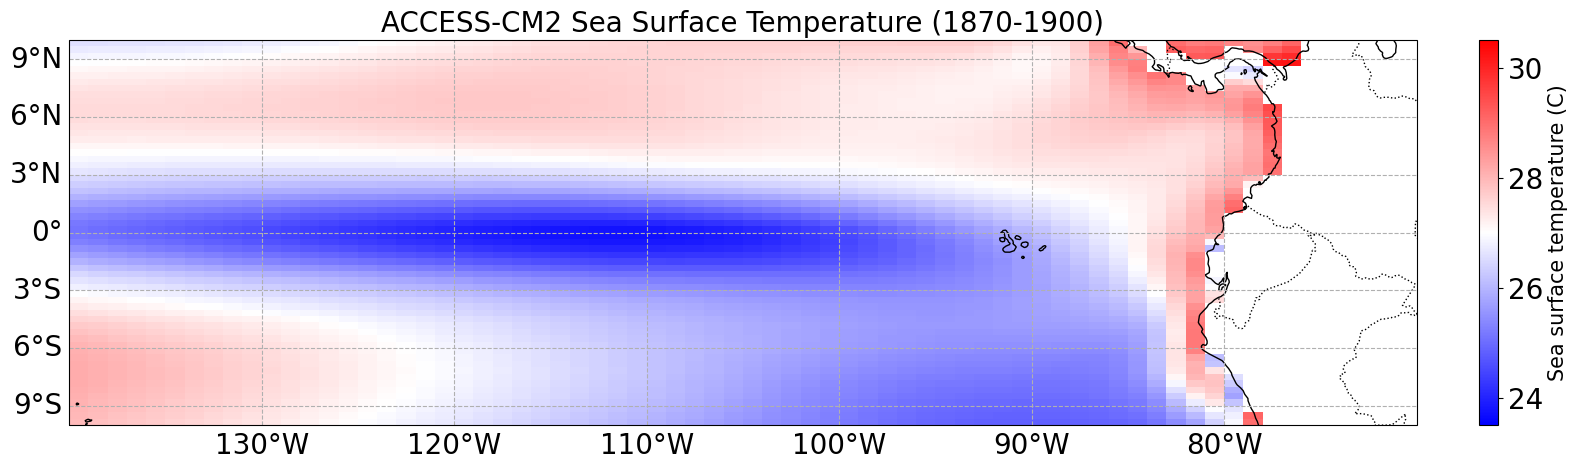

In [109]:
### ACCESS-CM2

## Map of ensemble average SST for early time period (1870-1900) 

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw={"projection": map})
# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(data_early_mn.longitude, data_early_mn.latitude, tos_early_ensmn, 
                     transform=map, cmap="bwr", vmin=23.5, vmax=30.5) #fix color bar

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax,fraction=0.046, pad=0.04)
cbar.set_label("Sea surface temperature (C)", fontsize=15)
cbar.ax.tick_params(labelsize=20)

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False
gl.right_labels = False

# Set font size for x, y-axis labels
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

# Add title, show plot
ax.set_title("ACCESS-CM2 Sea Surface Temperature (1870-1900)", fontsize= 20)

plt.show()


**MPI-ESM1-2-LR**

MPI-ESM1-2-LR shows similar spatial trends in temperature across the early time period, although the overall temperatures are lower than that of ACCESS-CM2. For instance, the cold tongue tempeatures are around 19 C compared to 23.5 C. Coastal areas, the tropical pacific north of around 4N, and the western part of the South Pacific are consistently warmer at around 30C, similar to ACCESS-CM2. Interestingly, the coldest region in this model is off the coast of Peru at around 10S rather than in the equatorial cold tongue. 

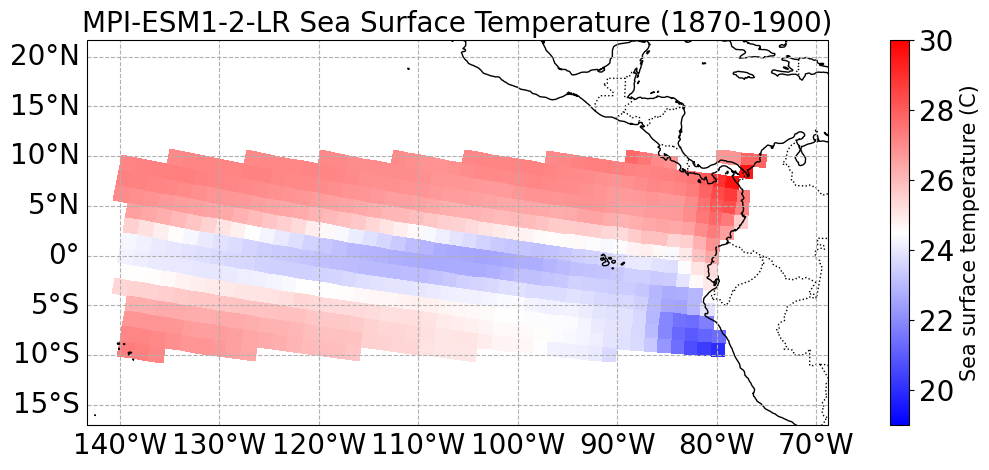

In [108]:
### MPI-ESM1-2-LR

## Map of ensemble average SST for early time period (1870-1900) 

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw={"projection": map})
# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(data_early_mn_2.longitude, data_early_mn_2.latitude, tos_early_ensmn_2, 
                     transform=map, cmap="bwr", vmin=19, vmax=30) #fix color bar

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax,fraction=0.046, pad=0.04)
cbar.set_label("Sea surface temperature (C)", fontsize=15)
cbar.ax.tick_params(labelsize=20)

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False
gl.right_labels = False

# Set font size for x, y-axis labels
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

# Add title, show plot
ax.set_title("MPI-ESM1-2-LR Sea Surface Temperature (1870-1900)", fontsize= 20)
plt.show()

### **Late Time Period (2070-2100)**

The following figures show the average SST in the ETP averaged across the late time period, 2070-2100, for both models (ACCESS-CM2 and MPI-ESM1-2-LR). Color bars are customized to the range of temperatures displayed on each map in order to be able to clearly see the variation in temperature across the region. 

**ACCESS-CM2**

For the late period average sea surface temperatures, similar spatial patterns persist (cold tongue, warmer temps north of the equator and along coastal areas). However, the coldest temperatures are 4 degrees warmer than in the early period (27.7C), and the warmest temperatures are around 3C warmer than in the early period (around 33C). 


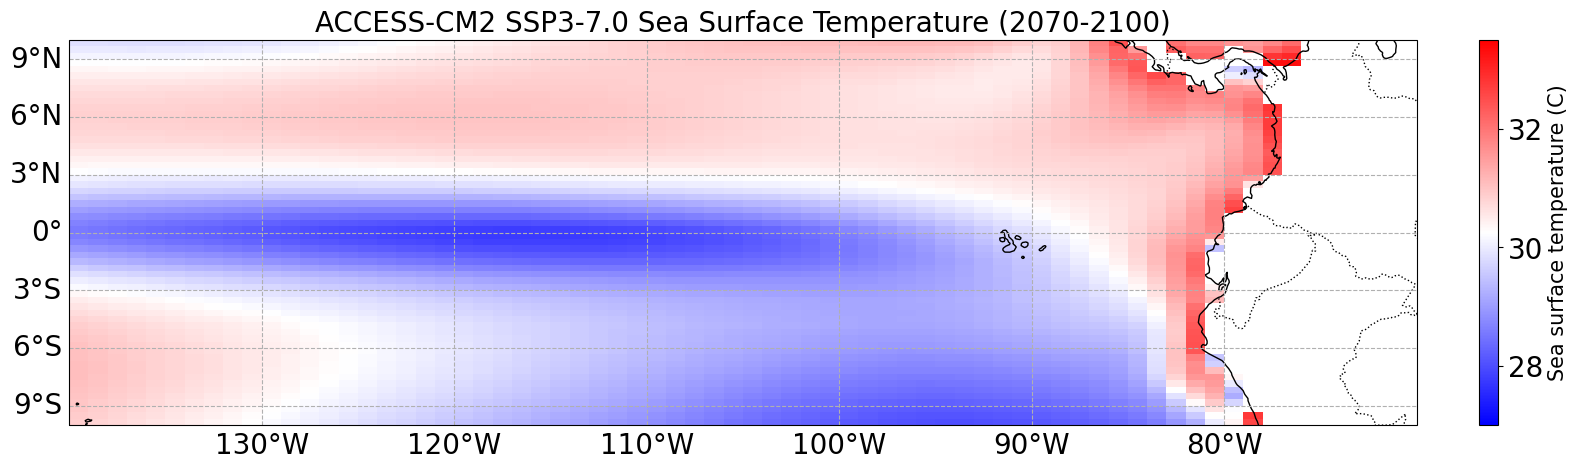

In [117]:
## Map of ensemble average SST for late time period (2070-2100) for SSP5-8.5

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw={"projection": map})
# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(data_early_mn.longitude, data_early_mn.latitude, tos_late_ensmn, 
                     transform=map, cmap="bwr", vmin=27, vmax=33.5) #fix color bar

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax,fraction=0.046, pad=0.04)
cbar.set_label("Sea surface temperature (C)", fontsize=15)
cbar.ax.tick_params(labelsize=20)

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False
gl.right_labels = False

# Set font size for x, y-axis labels
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

# Add title, show plot
ax.set_title("ACCESS-CM2 SSP3-7.0 Sea Surface Temperature (2070-2100)", fontsize= 20)

plt.show()


**MPI-ESM1-2-LR**

Similar to the other model, the average ocean temperatures in the late period are higher than those in the early period. Again, consistent with the late period, average temperatures projected by MPI-ESM1-2-LR are much lower than those projected by ACCESS-CM2, ranging from around 23-32C compared to around 28-33C. Again, the coldest region in this model is off the coast of Peru at around 10S.

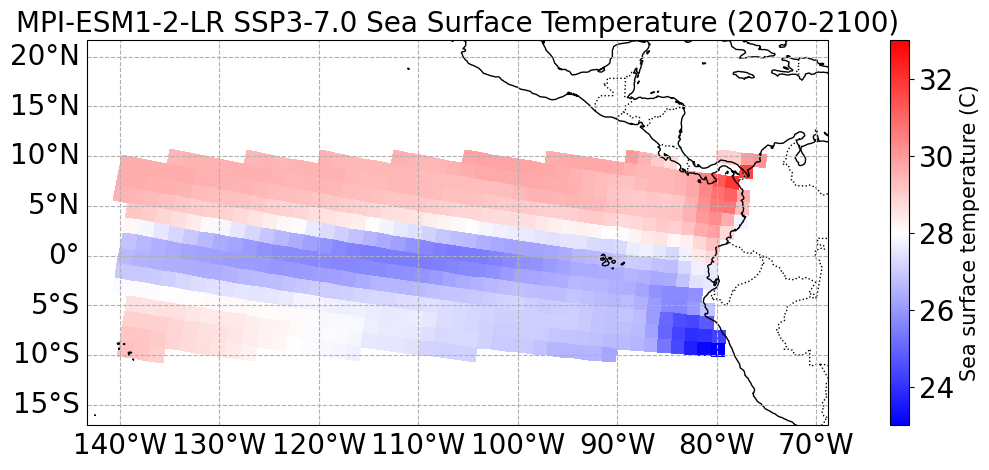

In [65]:
# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw={"projection": map})
# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(data_late_mn_2.longitude, data_late_mn_2.latitude, tos_late_ensmn_2, 
                     transform=map, cmap="bwr", vmin=23, vmax=33) #fix color bar

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax,fraction=0.046, pad=0.04)
cbar.set_label("Sea surface temperature (C)", fontsize=15)
cbar.ax.tick_params(labelsize=20)

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False
gl.right_labels = False

# Set font size for x, y-axis labels
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

# Add title, show plot
ax.set_title("MPI-ESM1-2-LR SSP3-7.0 Sea Surface Temperature (2070-2100)", fontsize= 20)

plt.show()

### Map of Difference Between the Two Time Periods

To more robustly compare the change in sea surface temperature from 1870-1900 to 2070-2100, the next two maps show the difference in time averaged temperatures between the late and early temperatures (late minus early).  

**ACCESS-CM2**

The largest change in temperature between the late and early time periods for the ACCESS-CM2 model is throughout the equatorial cold tonge, with an increase in temperature over the 200 year time period of about 4.5C. North and south of the equator also experiences increases in temperature but of a lesser degree, around 3C. 

In [66]:
# Calculate ensemble-mean epoch difference for ACCESS-CM2 
ensmn_diff = tos_late_ensmn - tos_early_ensmn

In [67]:
print(ensmn_diff)

[[2.9396038 2.9322453 2.9259968 ...       nan       nan       nan]
 [2.9364376 2.9298954 2.9241962 ...       nan       nan       nan]
 [2.9331493 2.9268456 2.921442  ...       nan       nan       nan]
 ...
 [3.2642155 3.246027  3.2287884 ...       nan       nan       nan]
 [3.2694435 3.249731  3.2323055 ...       nan       nan       nan]
 [3.279623  3.2602825 3.2442417 ...       nan       nan       nan]]


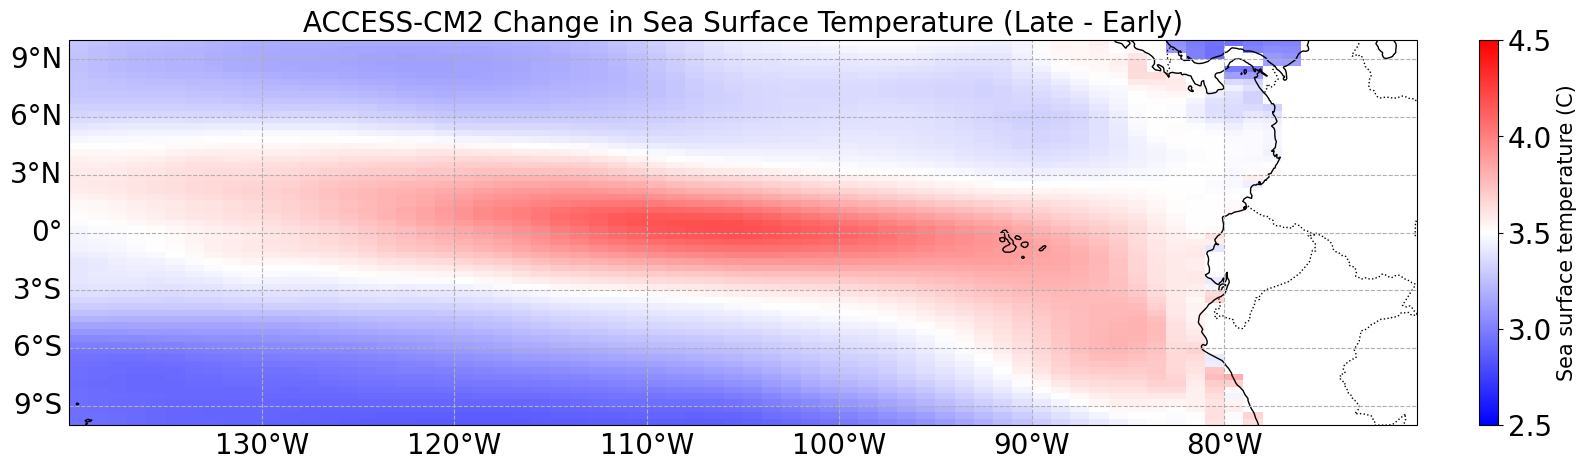

In [106]:
# Map the ensemble-mean epoch difference for ACCESS-CM2 

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw={"projection": map})
# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(data_early_mn.longitude, data_early_mn.latitude, ensmn_diff, 
                     transform=map, cmap="bwr", vmin=2.5, vmax=4.5)

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax,fraction=0.046, pad=0.04)
cbar.set_label("Sea surface temperature (C)", fontsize=15)
cbar.ax.tick_params(labelsize=20)

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False
gl.right_labels = False

# Set font size for x, y-axis labels
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}


# Statistical significance for historical vs future precip change regressed on gradient change
#latitudes, longitudes = np.where(tos_pvals_rs < 0.05)
#lats = data_early_mn.coords['latitude'][latitudes].values ## use early and late mean that are still df's so they have lat and lon
#lons = data_late_mn.coords['longitude'][longitudes].values
#ax.scatter(lons, lats, color='grey', s=0.05, transform=ccrs.PlateCarree())

### issues with this! all of the grid points have a significance dot, even ones over land that should be nan

# Add title, show plot
ax.set_title("ACCESS-CM2 Change in Sea Surface Temperature (Late - Early)", fontsize= 20)
plt.show()


**MPI-ESM1-2-LR**

The increase in sea surface temperature from the late to early periods in the MPI-ESM1-2-LR model is less than that in ACCESS-CM2. The largest temperature increase is in the equatorial region and the eastern Pacific off the coast of Peru, with an increase in around 3-3.5C over the 200 years. There is an increase of about 1.5C along the coastal areas of Central America and in the central Pacific around 10S. 

In [69]:
# Calculate ensemble-mean epoch difference for MPI-ESM1-2-LR
ensmn_diff_2 = tos_late_ensmn_2 - tos_early_ensmn_2

In [70]:
print(ensmn_diff_2)

[[      nan       nan       nan ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan       nan]
 ...
 [      nan       nan 2.1556263 ...       nan       nan       nan]
 [      nan       nan 2.0193424 ...       nan       nan       nan]
 [      nan       nan 1.9324951 ...       nan       nan       nan]]


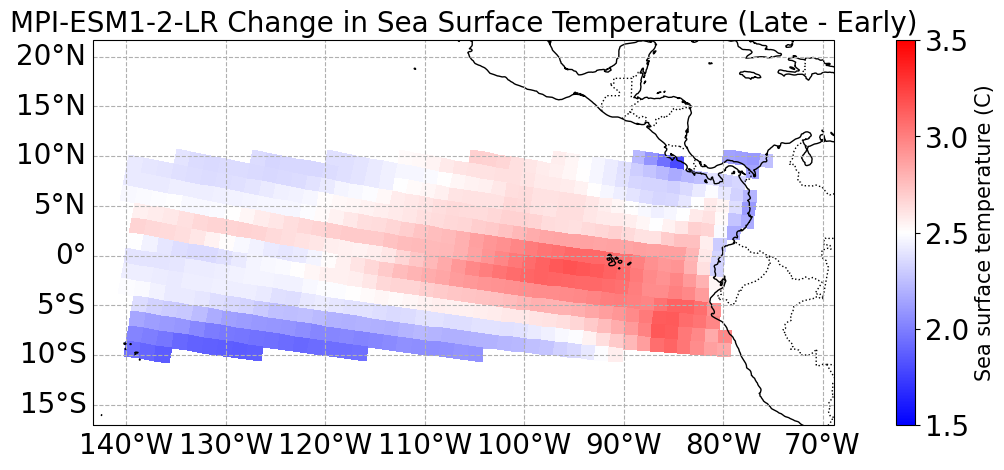

In [104]:
# Map ensemble mean difference for for MPI-ESM1-2-LR

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw={"projection": map})
# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(data_early_mn_2.longitude, data_early_mn_2.latitude, ensmn_diff_2, 
                     transform=map, cmap="bwr", vmin=1.5, vmax=3.5)

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax,fraction=0.046, pad=0.04)
cbar.set_label("Sea surface temperature (C)", fontsize=15)
cbar.ax.tick_params(labelsize=20)

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False
gl.right_labels = False

# Set font size for x, y-axis labels
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

# Add title
ax.set_title("MPI-ESM1-2-LR Sea Surface Temperature (Late - Early)", fontsize= 20)

# Statistical significance for historical vs future precip change regressed on gradient change
#latitudes, longitudes = np.where(tos_pvals_rs_2 < 0.05)
#lats = data_early_mn.coords['latitude'][latitudes].values ## use early and late mean that are still df's so they have lat and lon
#lons = data_late_mn.coords['longitude'][longitudes].values
#ax.scatter(lons, lats, color='grey', s=0.05, transform=ccrs.PlateCarree())

## issues with significance stipling -- seems like some latitudes have all the same p-value for the rank sum test? 
#doesn't match up with highest change in temperature 

# Add title, show plot
ax.set_title("MPI-ESM1-2-LR Change in Sea Surface Temperature (Late - Early)", fontsize= 20)
plt.show()


## Discussion 

While both models show an increase in temperature between 1870-1900 and 2070-2100, the magnitude and spatial distribution of that increase varies across models. Notably, MPI-ESM1-2-LR shows the eastern Pacific area off the coast of Peru at around 10S to be much colder than calculated by ACCESS-CM2. ACCESS-CM2 is generally warmer overall by a few degrees C, and the range of increase in temperature between the late and early temperatures is about 1C more. 

These results show that differences between model projections can be dramatic, suggesting different levels of severity of ecological impacts. This demonstrates that it is important to analyze multiple models when trying to discern the ecological implications of warming, and multi-model means may often be the most reliable representation of potential climate futures, taking into account the many assumptions made and other differences between models. 

Either way, according to both models analyzed here, we can be fairly certain that the eastern tropical Pacific Ocean will experience warming in the next century, likely having cascading impacts on the thriving ecosystems that call it home. As the ocean warms in the equatorial region, the ocean will become more stratified, decreasing upwelling and therefore decreasing the nutrients brought to the surface from the deep ocean. This may cause a decline in primary production, which in turn may cause a decline in productivity of the fisheries in the region. Given the economic importance of tuna and other fisheries in the ETP, this may have significant economic impacts for South American countries. Many people rely on these fisheries for their wellbeing overall, so a decline in this food source could reduce the amount of healthy protein available to those who rely on it. 